
This notebook uses the outputs
--- workflow/rules/20_preprocessing::prep_t2t_seq_class_cache_file
--- data/sample_phylo_order.tsv
--- workflow/rules/75_assm_stats::dump_suppl_tables_contiguity
--- workflow/rules/75_assm_stats::merge_all_sequence_class_annotations
as input, and produces the assembly contiguity heatmap for figure 1.

Repository directory:  /home/local/work/code/github/project-male-assembly
Execution directory:  /home/local/work/code/github/project-male-assembly/notebooks/plotting/contig_heatmap
Working directory:  /home/local/work/data/sig_chrY/paper
Output directory:  /home/local/work/data/sig_chrY/paper/output/figures


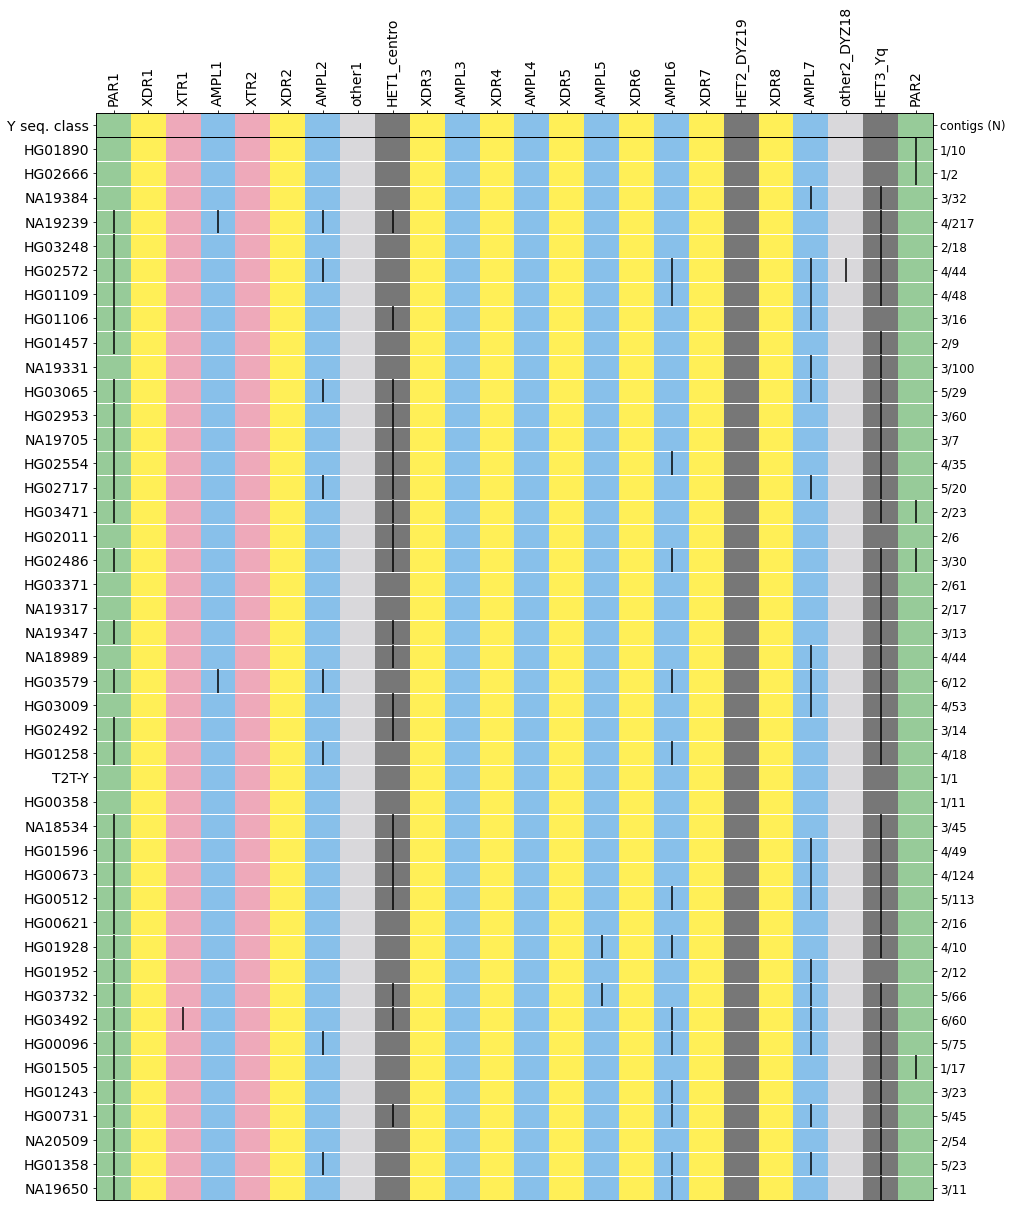

In [25]:
import pathlib as pl

import pandas as pd
import numpy as np
import collections as collect

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.colors as colors
import matplotlib.patches as mpt

# required to have text output as "text fields"
# and not individual objects
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

save_plots = True

build_version = 'main'  # or main

desc="""
This notebook uses the outputs
--- workflow/rules/20_preprocessing::prep_t2t_seq_class_cache_file
--- data/sample_phylo_order.tsv
--- workflow/rules/75_assm_stats::dump_suppl_tables_contiguity
--- workflow/rules/75_assm_stats::merge_all_sequence_class_annotations
as input, and produces the assembly contiguity heatmap for figure 1.
"""

print(desc)

repo_dir = pl.Path('/home/local/work/code/github/project-male-assembly').resolve(strict=True)
exec_dir = pl.Path('.').resolve(strict=True)
wd_dir = pl.Path('/home/local/work/data/sig_chrY/paper').resolve(strict=True)
out_dir = pl.Path('/home/local/work/data/sig_chrY/paper/output/figures').resolve(strict=True)

print('Repository directory: ', repo_dir)
print('Execution directory: ', exec_dir)
print('Working directory: ', wd_dir)
print('Output directory: ', out_dir)
print('=================================')

drop_samples = [
    'HG02666',
    'NA19384',
    'HG01457',
    'NA18989',
    'NA24385',
    'HG03456'
]

seq_classes_t2t_file = wd_dir / pl.Path('annotation_tables', 'T2T.chrY-seq-classes.tsv')
sqcls_t2t = pd.read_csv(seq_classes_t2t_file, header=0, sep='\t')

# The sample order in the phylogenetic tree starts at 1 (biologists...),
# which is fitting here because at row index 0, the sequence classes
# should be plotted. Additionally, the T2T sample is included in the sample
# order at position 28.
phylo_order_file = repo_dir / pl.Path('data', 'sample_phylo_order.tsv')
phylo_order = pd.read_csv(phylo_order_file, sep='\t', header=0)
phylo_order.sort_values('order_top', ascending=True, inplace=True)
phylo_order = phylo_order.loc[~phylo_order['sample'].isin(drop_samples), :].copy()

# table with counts of contigs per sequence class
numctg_table = wd_dir / pl.Path('stats/contiguity', 'numctg-seqcls.by-sample.HIFIRW.ONTUL.na.chrY.pivot.tsv')
numctg = pd.read_csv(numctg_table, sep='\t', header=0, index_col=0, comment='#')

# table with indicator "is_contiguous"
isctg_table = wd_dir / pl.Path('stats/contiguity', 'ctgassm-seqcls.by-sample.HIFIRW.ONTUL.na.chrY.pivot.tsv')
isctg = pd.read_csv(isctg_table, sep='\t', header=0, index_col=0, comment='#')

# table with info on total number of contigs and min #contigs for max contiguity
minmax_table = wd_dir / pl.Path('stats/contiguity', 'SAMPLES.HIFIRW.ONTUL.na.chrY.seqclasses.tsv')
minmax = pd.read_csv(minmax_table, sep='\t', header=0, index_col=0, comment='#')
minmax = minmax[['sample', 'contigs_total_num', 'contigs_minmax_num']].drop_duplicates('sample', inplace=False)

# 44 samples plus sequence classes at top plus T2T-Y in the middle
plot_data = np.ones((phylo_order.shape[0] + 1, sqcls_t2t.shape[0], 3), dtype=np.float32)
assert plot_data.shape[0] == 45

name_col_idx_map = dict()
seq_class_names = []

color_map = collect.OrderedDict({
    1: 'lightsteelblue',
    2: 'mistyrose',
    3: 'lightsalmon',
    4: 'lightsalmon',
    5: 'lightcoral',
    6: 'lightcoral',
    7: 'tomato',
    8: 'tomato',
    9: 'orangered',
    10: 'orangered'
})

row_idx = 0
red, green, blue = 0, 1, 2
column_color_map = dict()
for row in sqcls_t2t.itertuples(index=True):
    plot_data[row_idx, row.Index, red] = row.red
    plot_data[row_idx, row.Index, green] = row.green
    plot_data[row_idx, row.Index, blue] = row.blue
    name_col_idx_map[row.name] = row.Index
    seq_class_names.append(row.name)
    column_color_map[row.Index] = row.red,row.green,row.blue,1
    if build_version == 'main':
        # this is the row of the T2T-Y
        plot_data[27, row.Index, red] = row.red
        plot_data[27, row.Index, green] = row.green
        plot_data[27, row.Index, blue] = row.blue

samples = ['Y seq. class']
breaklines_x = []
breaklines_y = []
right_y_ticklabels = ['contigs (N)']
row_lines = []

for row in phylo_order.itertuples():
    if row.sample in drop_samples:
        continue
    row_idx = row.order_top
    row_lines.append(row_idx + 0.5)
    sample = row.sample
    if row_idx == 27:
        assert sample == 'T2T-Y'
        samples.append(sample)
        r,g,b,a = colors.to_rgba(color_map[1])
        if build_version == 'supplement':
            plot_data[row_idx, :, red] = r
            plot_data[row_idx, :, green] = g
            plot_data[row_idx, :, blue] = b
        right_y_ticklabels.append('1/1')
        continue
    sample_counts = numctg.loc[sample, :]
    sample_isctg = isctg.loc[sample, :]
    total_ctg = minmax.loc[minmax['sample'] == sample, 'contigs_total_num'].values[0]
    min_ctg = minmax.loc[minmax['sample'] == sample, 'contigs_minmax_num'].values[0]
    if sample.startswith('HC'):
        if sample in ['HC02666', 'HC01457']:
            sample = sample.replace('HC', 'HG')
        else:
            sample = sample.replace('HC', 'NA')
    samples.append(sample)
    for column, (count, is_ctg) in enumerate(zip(sample_counts.values, sample_isctg.values)):
        count_color = color_map.get(int(count), 'red')
        r,g,b,a = colors.to_rgba(count_color)
        if build_version == 'main':
            r,g,b,a = column_color_map[column]
        plot_data[row_idx, column, red] = r
        plot_data[row_idx, column, green] = g
        plot_data[row_idx, column, blue] = b
        if is_ctg == 0:
            breaklines_x.append(column)
            breaklines_y.append(row_idx - 0.5)
    
    right_y_ticklabels.append(f'{min_ctg}/{total_ctg}')
    
fig, ax = plt.subplots(figsize=(15,20))
_ = ax.imshow(plot_data, aspect='auto')
_ = ax.set_yticks(np.arange(plot_data.shape[0]))
_ = ax.set_yticklabels(samples, fontsize=14)

ax2 = ax.twinx()
_ = ax2.set_yticks(np.arange(plot_data.shape[0]))
_ = ax2.set_yticklabels(right_y_ticklabels, fontsize=12)
_ = ax2.yaxis.tick_right()
ax2.set_ylim(ax.get_ylim())

_ = ax.set_xticks(np.arange(len(seq_class_names)))
_ = ax.set_xticklabels(seq_class_names, fontsize=14, rotation=90)
_ = ax.xaxis.tick_top()

_ = ax.vlines(
    breaklines_x,
    breaklines_y,
    np.array(breaklines_y, dtype=np.float16) + 0.98,
    colors='black'
)

if build_version == 'main':
    _ = ax.hlines(
        row_lines,
        -0.5, 23.5,
        color='white',
        ls='solid',
        zorder=1,
        lw=1
    )
    _ = ax.hlines(
        min(row_lines) - 1,
        -0.5, 23.5,
        color='black',
        ls='solid',
        zorder=1,
        lw=1
    )

if build_version == 'supplement':
    legend = []
    for k, v in color_map.items():
        if k % 2 == 0 and k > 2:
            continue
        if k < 3:
            label=f'{k}'
        else:
            label=f'{k}-{k+1}'
        legend.append(
            mpt.Patch(
                facecolor=v,
                edgecolor=v,
                label=label
            )
        )

    legend.append(
        mpt.Patch(
            facecolor='red',
            edgecolor='red',
            label='>10'
        )
    )

    fig_legend = ax.legend(
        handles=legend,
        bbox_to_anchor=(1.2, 0.5),
        title='# contigs',
        fontsize=14
    )
    fig_legend.get_title().set_fontsize(16)
 
    
if save_plots and build_version == 'supplement':
    plt.savefig(
        out_dir / pl.Path('fig1_contiguity_matrix_suppl.pdf'),
        bbox_inches='tight',
        bbox_extra_artists=[fig_legend]
    )
    plt.savefig(
        out_dir / pl.Path('fig1_contiguity_matrix_suppl.png'),
        bbox_inches='tight',
        bbox_extra_artists=[fig_legend],
        dpi=150
    )
    
if save_plots and build_version == 'main':
    plt.savefig(
        out_dir / pl.Path('fig1_contiguity_matrix_main.pdf'),
        bbox_inches='tight',
        bbox_extra_artists=[]
    )
    plt.savefig(
        out_dir / pl.Path('fig1_contiguity_matrix_main.png'),
        bbox_inches='tight',
        bbox_extra_artists=[],
        dpi=150
    )